In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None, engine="pyarrow")
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [6]:
# Normalize the data to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-07 21:54:30.339444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 21:54:30.340377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# train the autoencoder using only normal rhythms
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

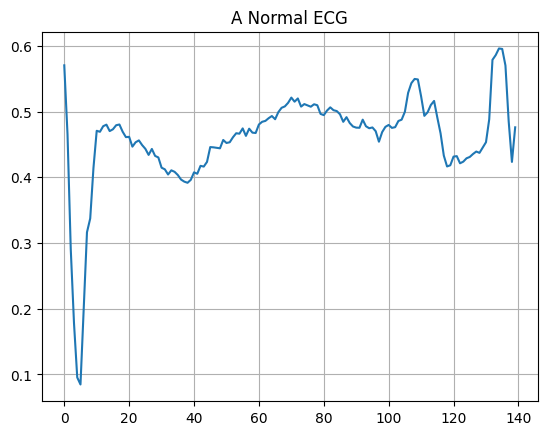

In [8]:
# Normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

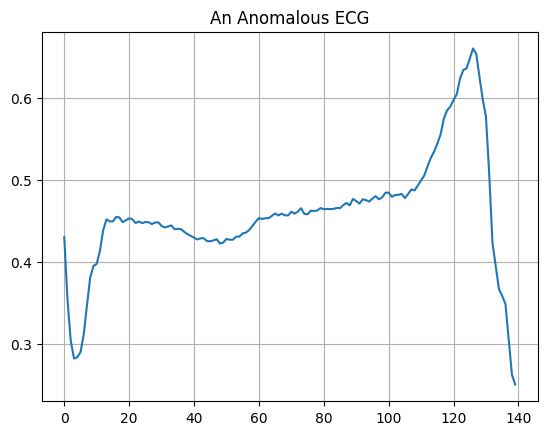

In [9]:
# Anomalous ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [10]:
# Build the model :) 
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")]
        )

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [11]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

In [12]:
# Validate using the full data set (although the training is done with the normal set only)
history = autoencoder.fit(normal_train_data,
                          normal_train_data,
                          epochs=20, 
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20


2023-04-07 21:59:34.519368: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 21:59:34.961530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 89ms/step - loss: 0.0582 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0562 - val_loss: 0.0517
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0538 - val_loss: 0.0498
Epoch 4/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0518

2023-04-07 21:59:36.715699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 10ms/step - loss: 0.0505 - val_loss: 0.0477
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0466 - val_loss: 0.0457
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0425 - val_loss: 0.0434
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0384 - val_loss: 0.0414
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0347 - val_loss: 0.0396
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0317 - val_loss: 0.0384
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0293 - val_loss: 0.0374
Epoch 11/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0275 - val_loss: 0.0366
Epoch 12/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0260 - val_loss: 0.0360
Epoch 13/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0248 - val_loss: 0.0355
Epoch 14/20
5/5 [=======================

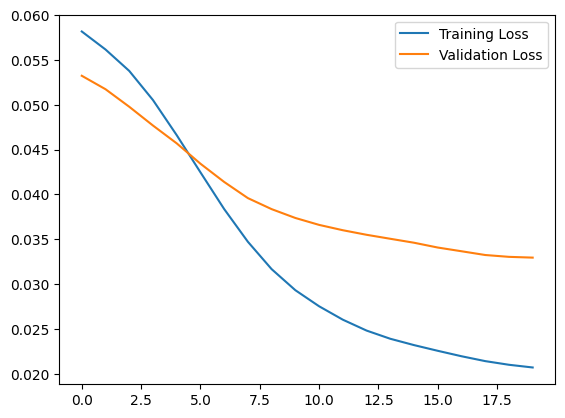

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

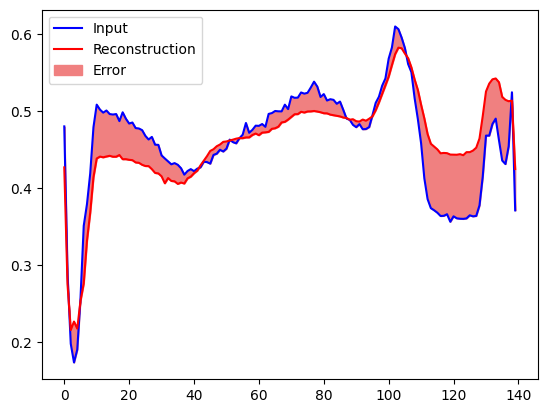

In [14]:
# normal
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

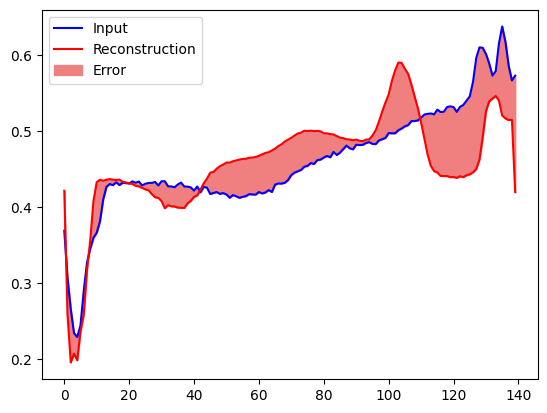

In [15]:
# anomalous
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

67/74 [==========================>...] - ETA: 0s

2023-04-07 22:02:21.929952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 0s 3ms/step


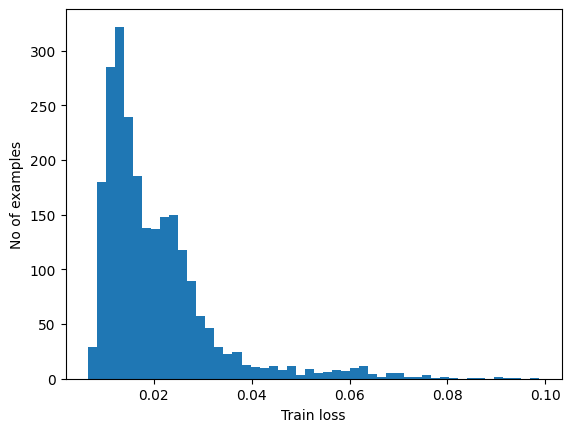

In [16]:
# detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [17]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032531977


14/14 [==============================] - 0s 4ms/step


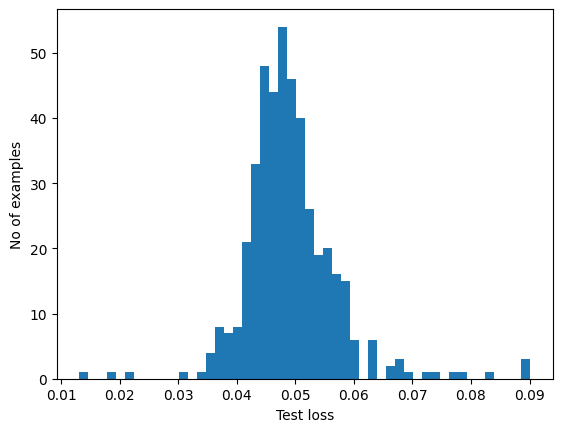

In [18]:
# may adjust the precision and recall by adjusting the threshold
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [19]:
# an ECG is an anomaly if the reconstruction error is greater than the threshold
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [20]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall = 0.9035714285714286


In [21]:
autoencoder.summary()

Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 5176      
                                                                 
 sequential_1 (Sequential)   (None, 140)               5308      
                                                                 
Total params: 10,484
Trainable params: 10,484
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.save('../models/autoencoder/model')

INFO:tensorflow:Assets written to: ../models/autoencoder/model/assets


In [24]:
new_model = tf.keras.models.load_model('../models/autoencoder/model')
new_model.summary()

Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 5176      
                                                                 
 sequential_1 (Sequential)   (None, 140)               5308      
                                                                 
Total params: 10,484
Trainable params: 10,484
Non-trainable params: 0
_________________________________________________________________
